# Пример 2: моделирование системы с известными спектрами компонент

В этом примере будет рассмотрен случай, более приближенный к реальности, чем в предыдущем: двойная звездная система, компоненты которой имеют разные спектральные классы. В этот раз больше внимания будет уделено не созданию модели, а процессу обработки данных.

Для используемого здесь подхода двойные звезды - наиболее сложные объекты. Гораздо проще изучать источники с яркими ненакладывающимися эмиссионными линиями - например, молодые звезды с джетами (см. [Whelan & Garcia 2008](https://ui.adsabs.harvard.edu/abs/2008LNP...742..123W/abstract)). Здесь же приходится особенно подробно рассматривать каждую линию и проверять, не влияют ли на координаты ее центра линии из спектра другой компоненты.

Но процесс моделирования по известным спектрам проще и требует гораздо меньше входных данных, чем при случайной генерации спектров.

In [1]:
from astropy.io import fits
from Spectroastrometry import *
from SAModel import *


file = fits.open('Stellar_spectra.fits')

image_size_X = 8000  # Размеры изображения в пикселях (NAXIS1)
image_size_Y = 400  # Размеры изображения в пикселях (NAXIS2)
pix_size = 0.37  # Угловой размер пикселя (arcsec)
CRVAL1 = file[0].header['CRVAL1']  # Стартовая длина волны
CDELT1 = file[0].header['CDELT1']  # Шаг по длине волны (дисперсия)
Y_est = 200  # Примерное положение центра спектра на кадре
sep = 0.1  # Смещение спектра 2 относительно спектра 1 (arcsec)
seeing = 1  # Размер атмосферных изображений (arcsec)
slit = 1  # Размер щели (arcsec)
RN = 3  # Шум считывания (ADU)
BN = 5  # Фон (ADU)

Спектры звезд взяты из [индо-американской библиотеки звездных спектров](https://ui.adsabs.harvard.edu/abs/2004ApJS..152..251V/abstract). В действительности выбранные звезды никак не связаны между собой, но это не мешает присвоить их спектры компонентам моделируемой системы.

Для создания кадра используется функция `Frame_model_known_spec`.

Модуль `Spectroastrometry` содержит функции для обработки наборов кадров: `Average_images(images)` и `Median_images(images)`, получающие на вход массив кадров и возвращающие усредненный кадр (в случае `Average_images`) или результат его медианной фильтрации (для `Median_images`). Здесь они не применяются, но могут быть полезны при обработке реальных наблюдений.

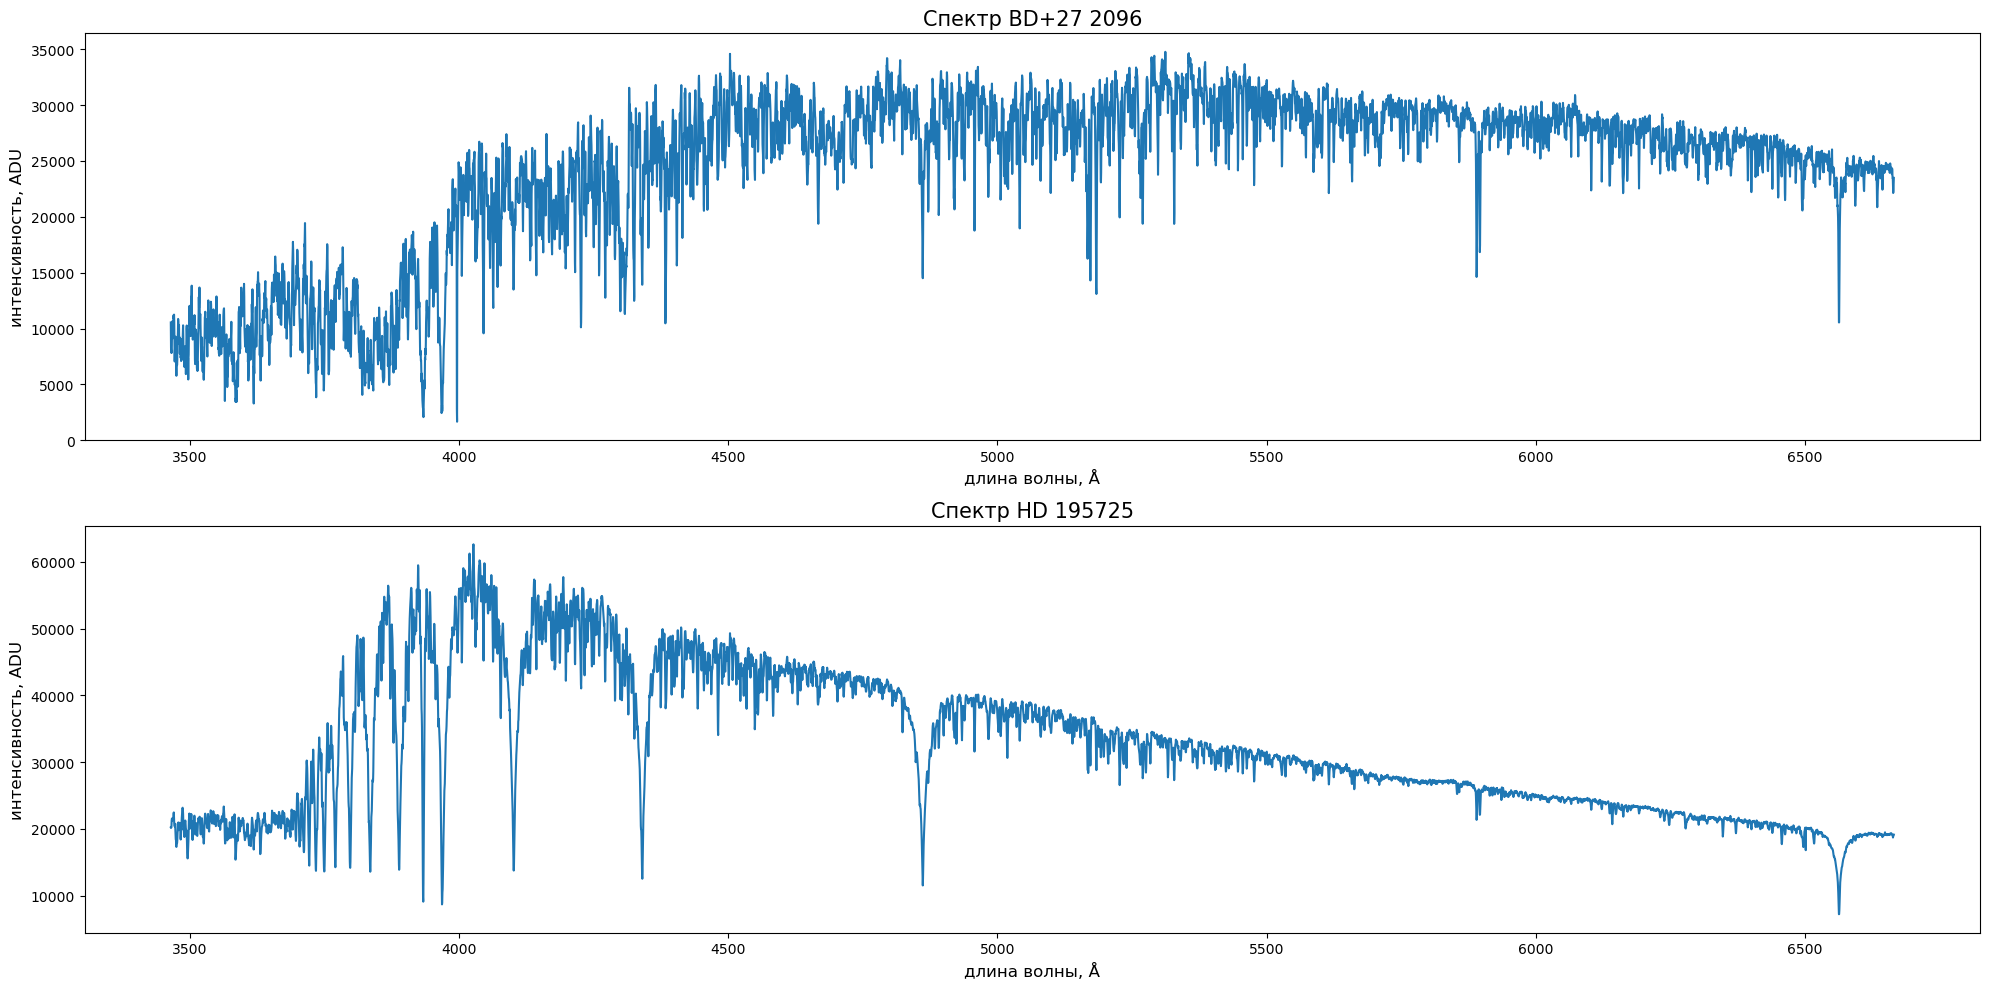

In [2]:
data = file[0].data
Num_1 = 661   # BD+27 2096
Num_2 = 1030  # HD 195725

Lambda = np.zeros(image_size_X)
Int1 = np.zeros(image_size_X)
Int2 = np.zeros(image_size_X)

for i in range(image_size_X):
    Lambda[i] = CRVAL1 + i * CDELT1
    Int1[i] = data[Num_1][i] * 30000  # Масштабируем интенсивность до реалистичных значений в ADU
    Int2[i] = data[Num_2][i] * 30000

fig1, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(Lambda, Int1, '-')
axes[0].set_xlabel("длина волны, Å", fontsize=12)
axes[0].set_ylabel("интенсивность, ADU", fontsize=12)
axes[0].set_title("Спектр BD+27 2096", fontsize=15)

axes[1].plot(Lambda, Int2, '-')
axes[1].set_xlabel("длина волны, Å", fontsize=12)
axes[1].set_ylabel("интенсивность, ADU", fontsize=12)
axes[1].set_title("Спектр HD 195725", fontsize=15)

plt.tight_layout()
plt.show()

image, PSF = Frame_model_known_spec(slit, seeing, sep, pix_size, CRVAL1, image_size_X, image_size_Y,
                                                  Y_est, CDELT1, RN, BN, Lambda, Int1, Lambda, Int2)

Поиск спектроастрометрического эффекта занимает наибольшее время по сравнению с остальными частями кода, поэтому он вынесен в отдельную ячейку. После его выполнения можно менять и запускать последующие ячейки без необходимости повторять эти вычисления при каждом запуске.

In [3]:
start = PSF.shape[0]
end = image_size_X - PSF.shape[0]
area = 20

LAMBDA, SPEC, CENTER, FWHM, ERRORBAR = Center_search(CRVAL1, CDELT1, start, end, area, Y_est, image)

Стоит отметить, что в реальных наблюдениях обычно присутствует тренд в координатах центра спектра. Он обусловлен конструкцией прибора и индивидуален для каждого инструмента и для каждого наблюдения (например, он может быть связан с неидеальной соосностью оптических элементов и несовпадением главной оптической оси с направлением на наблюдаемый источник). Такой тренд устраняется путем вычитания скользящего среднего из полученных значений центров яркости. В модуле `Spectroastrometry` это реализовано в функции `Detrend(window, CENTER)`, где `window` - размер окна для вычисления скользящего среднего (подбирается под конкретный прибор). Функция возвращает 2 массива, содержащие отклонения центра от скользящего среднего, а также само скользящее среднее.

Также модуль содержит функцию `remove_polynomial_trend(CENTER, n)`, где `n` - степень полинома, которым аппроксимируется массив центров яркости `CENTER`. Функция возвращает массив, который содержит разность центров яркости и значений аппроксимирующего полинома.

Устранить оставшиеся инструментальные дефекты можно, если проводить наблюдения при двух позиционных углах, отличающихся на $180^{\circ}$. Тогда отклонения центра, связанные с прибором, останутся неизменными, а связанные с наблюдаемым источником - сменят знак. Следовательно, вычитая друг из друга центры, найденные при таких углах, получим удвоенное смещение центра, вызванное только самим объектом исследования.

При моделировании тренд в данные не закладывается, поэтому здесь его учет не требуется. 

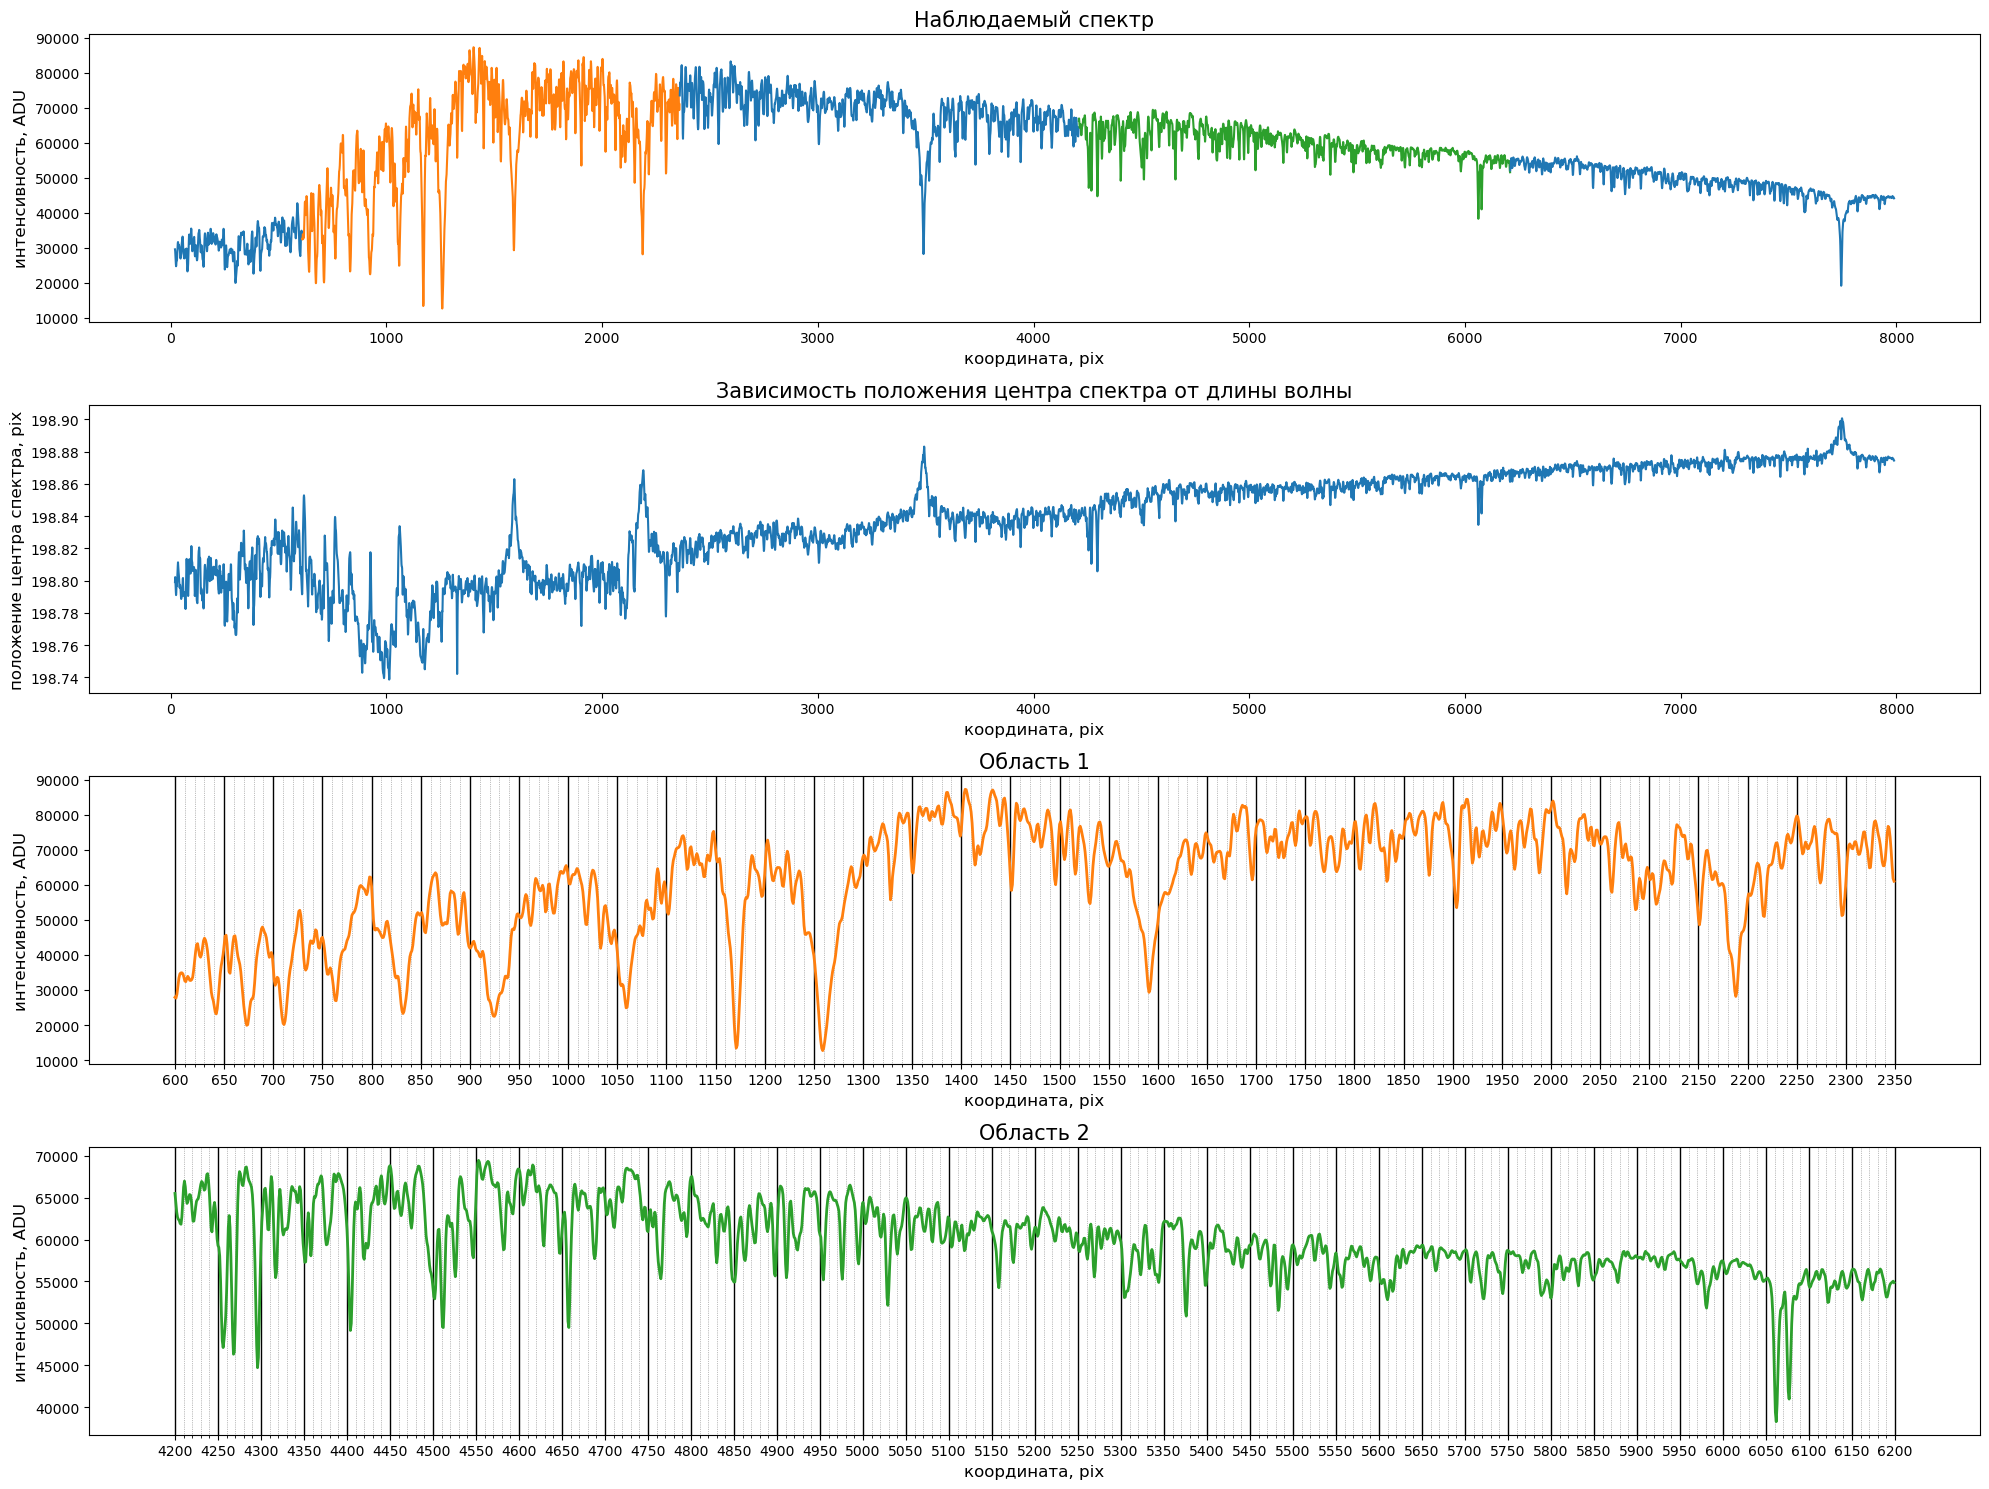

In [4]:
fig2, axes = plt.subplots(4, 1, figsize=(20, 15))

start1 = 600         # Диапазоны спектра,
end1 = 2350          # которые будут
                     # использоваться
start2 = 4200        # для определения
end2 = 6200          # разделения звезд

axes[0].plot((LAMBDA[start:start1] - CRVAL1) / CDELT1, SPEC[start:start1], '-', color='C0')
axes[0].plot((LAMBDA[start1:end1] - CRVAL1) / CDELT1, SPEC[start1:end1], '-', color='C1')
axes[0].plot((LAMBDA[end1:start2] - CRVAL1) / CDELT1, SPEC[end1:start2], '-', color='C0')
axes[0].plot((LAMBDA[start2:end2] - CRVAL1) / CDELT1, SPEC[start2:end2], '-', color='C2')
axes[0].plot((LAMBDA[end2:end] - CRVAL1) / CDELT1, SPEC[end2:end], '-', color='C0')
axes[0].set_xlabel("координата, pix", fontsize=12)
axes[0].set_ylabel("интенсивность, ADU", fontsize=12)
axes[0].set_title("Наблюдаемый спектр", fontsize=15)

axes[1].plot((LAMBDA[start:end] - CRVAL1) / CDELT1, (CENTER[start:end]), '-')
axes[1].set_xlabel("координата, pix", fontsize=12)
axes[1].set_ylabel("положение центра спектра, pix", fontsize=12)
axes[1].set_title("Зависимость положения центра спектра от длины волны", fontsize=15)

axes[2].plot((LAMBDA[start1 - start:end1 - start] - CRVAL1) / CDELT1, SPEC[start1 - start:end1 - start], '-', color='C1', linewidth=2)
axes[2].set_xlabel("координата, pix", fontsize=12)
axes[2].set_ylabel("интенсивность, ADU", fontsize=12)
axes[2].set_title("Область 1", fontsize=15)

axes[2].set_xticks(np.arange(start1, end1 + 1, 10), minor=True) 
axes[2].grid(which='minor', linestyle=':', linewidth=0.5, color='gray', axis='x')

axes[2].set_xticks(np.arange(start1, end1 + 1, 50))
axes[2].grid(which='major', linestyle='-', linewidth=1, color='black', axis='x')

axes[3].plot((LAMBDA[start2 - start:end2 - start] - CRVAL1) / CDELT1, SPEC[start2 - start:end2 - start], '-', color='C2', linewidth=2)
axes[3].set_xlabel("координата, pix", fontsize=12)
axes[3].set_ylabel("интенсивность, ADU", fontsize=12)
axes[3].set_title("Область 2", fontsize=15)

axes[3].set_xticks(np.arange(start2, end2 + 1, 10), minor=True) 
axes[3].grid(which='minor', linestyle=':', linewidth=0.5, color='gray', axis='x')

axes[3].set_xticks(np.arange(start2, end2 + 1, 50))
axes[3].grid(which='major', linestyle='-', linewidth=1, color='black', axis='x')

plt.tight_layout()
plt.show()

Для начала рассмотрим звезду, центр которой на кадре расположен "выше". Так как все линии в наблюдаемом спектре соответствуют поглощению, то в линиях этой звезы будет наблюдаться смещение центра спектра "вниз" на кривой спектроастрометрического эффекта (см. второй график).

In [5]:
# Линия 1

y_values = [1320, 1322, 1325, 1326, 1328, 1330, 1333, 1335]

centers11 = []
errors11 = []
for y in y_values:
    line, error = Line_center_search(image, 1327, y, Y_est, area)
    centers11.append(line[2])
    errors11.append(error)

print('\n')
print(f'Линия {1327 * CDELT1 + CRVAL1:.1f} Å')
print('------------------------------------')
print('Континуум    |   Координата (pix)   ')
print('------------------------------------')

for i in range(len(y_values)):
    y_value = y_values[i] * CDELT1 + CRVAL1
    displacement = centers11[i]
    print(f"{y_value} Å     | {displacement}")

# Линия 2

y_values = [5150, 5152, 5154, 5155, 5160, 5161, 5162, 5165]

centers12 = []
errors12 = []
for y in y_values:
    line, error = Line_center_search(image, 5158, y, Y_est, area)
    centers12.append(line[2])
    errors12.append(error)

print('\n')
print(f'Линия {5158 * CDELT1 + CRVAL1:.1f} Å')
print('------------------------------------')
print('Континуум    |   Координата (pix)   ')
print('------------------------------------')

for i in range(len(y_values)):
    y_value = y_values[i] * CDELT1 + CRVAL1
    displacement = centers12[i]
    print(f"{y_value} Å     | {displacement}")

# Линия 3

y_values = [6051, 6052, 6055, 6057, 6064, 6065, 6066, 6067]

centers13 = []
errors13 = []
for y in y_values:
    line, error = Line_center_search(image, 6060, y, Y_est, area)
    centers13.append(line[2])
    errors13.append(error)

print('\n')
print(f'Линия {6060 * CDELT1 + CRVAL1:.1f} Å')
print('------------------------------------')
print('Континуум    |   Координата (pix)   ')
print('------------------------------------')

for i in range(len(y_values)):
    y_value = y_values[i] * CDELT1 + CRVAL1
    displacement = centers13[i]
    print(f"{y_value} Å     | {displacement}")



Линия 3995.8 Å
------------------------------------
Континуум    |   Координата (pix)   
------------------------------------
3993.0 Å     | 198.92497417956787
3993.8 Å     | 198.92608385456893
3995.0 Å     | 198.9674260707385
3995.4 Å     | 198.98207829095557
3996.2 Å     | 198.96655861117006
3997.0 Å     | 199.55858367287792
3998.2 Å     | 199.04811220456057
3999.0 Å     | 198.96332261331088


Линия 5528.2 Å
------------------------------------
Континуум    |   Координата (pix)   
------------------------------------
5525.0 Å     | 198.92176814936644
5525.8 Å     | 198.92978909224263
5526.6 Å     | 198.94811484460197
5527.0 Å     | 198.95684256539235
5529.0 Å     | 198.92429892002428
5529.4 Å     | 198.92529827993278
5529.8 Å     | 198.9220770932633
5531.0 Å     | 198.91780877449958


Линия 5889.0 Å
------------------------------------
Континуум    |   Координата (pix)   
------------------------------------
5885.4 Å     | 198.92504993413795
5885.8 Å     | 198.92677618823822
5887.0

Дополнительную трудность для обработки такой системы, как здесь, дает разная ширина линий. Узкая линия может целиком накладываться на часть широкой. В результате координата центра будет меняться в зависимости от выбора точки континуума, как показано на графике ниже. Такие линии не рассматриваются и в таблицах их нет.

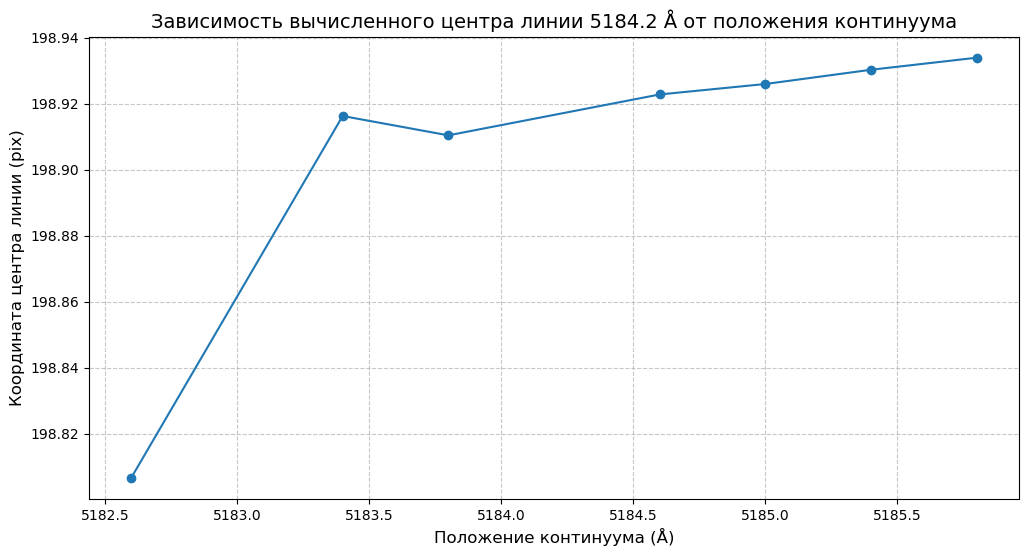

In [6]:
y_values = [4294, 4296, 4297, 4299, 4300, 4301, 4302]

centers = []
errors = []
for y in y_values:
    line, error = Line_center_search(image, 4298, y, Y_est, area)
    centers.append(line[2])
    errors.append(error)

wavelengths = [y * CDELT1 + CRVAL1 for y in y_values]

plt.figure(figsize=(12, 6))
plt.plot(wavelengths, centers, 'o-')
plt.title(f'Зависимость вычисленного центра линии {4298 * CDELT1 + CRVAL1:.1f} Å от положения континуума', fontsize=14)
plt.xlabel('Положение континуума (Å)', fontsize=12)
plt.ylabel('Координата центра линии (pix)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

Теперь обработаем линии второй звезды. Они шире и в них больше наложений. Тем не менее, несколько подходящих нашлось.

In [7]:
# Линия 1

y_values = [638, 639, 640, 641, 643, 644, 645, 646]

centers21 = []
errors21 = []
for y in y_values:
    line, error = Line_center_search(image, 642, y, Y_est, area)
    centers21.append(line[2])
    errors21.append(error)

print('\n')
print(f'Линия {642 * CDELT1 + CRVAL1:.1f} Å')
print('------------------------------------')
print('Континуум    |   Координата (pix)   ')
print('------------------------------------')

for i in range(len(y_values)):
    y_value = y_values[i] * CDELT1 + CRVAL1
    displacement = centers21[i]
    print(f"{y_value} Å     | {displacement}")

# Линия 2

y_values = [1167, 1168, 1169, 1170, 1172, 1173, 1174, 1175]

centers22 = []
errors22 = []
for y in y_values:
    line, error = Line_center_search(image, 1171, y, Y_est, area)
    centers22.append(line[2])
    errors22.append(error)

print('\n')
print(f'Линия {1171 * CDELT1 + CRVAL1:.1f} Å')
print('------------------------------------')
print('Континуум    |   Координата (pix)   ')
print('------------------------------------')

for i in range(len(y_values)):
    y_value = y_values[i] * CDELT1 + CRVAL1
    displacement = centers22[i]
    print(f"{y_value} Å     | {displacement}")

# Линия 3

y_values = [1255, 1256, 1257, 1258, 1260, 1261, 1262, 1263]

centers23 = []
errors23 = []
for y in y_values:
    line, error = Line_center_search(image, 1259, y, Y_est, area)
    centers23.append(line[2])
    errors23.append(error)

print('\n')
print(f'Линия {1259 * CDELT1 + CRVAL1:.1f} Å')
print('------------------------------------')
print('Континуум    |   Координата (pix)   ')
print('------------------------------------')

for i in range(len(y_values)):
    y_value = y_values[i] * CDELT1 + CRVAL1
    displacement = centers23[i]
    print(f"{y_value} Å     | {displacement}")



Линия 3721.8 Å
------------------------------------
Континуум    |   Координата (pix)   
------------------------------------
3720.2 Å     | 198.6846619193819
3720.6 Å     | 198.7139986500403
3721.0 Å     | 198.71020234690909
3721.4 Å     | 198.5529395110624
3722.2 Å     | 198.87834590733672
3722.6 Å     | 198.83975225219623
3723.0 Å     | 198.8291114863681
3723.4 Å     | 198.825098680874


Линия 3933.4 Å
------------------------------------
Континуум    |   Координата (pix)   
------------------------------------
3931.8 Å     | 198.73522417459782
3932.2 Å     | 198.73394849336407
3932.6 Å     | 198.73724347106355
3933.0 Å     | 198.7498167411634
3933.8 Å     | 198.6521991860367
3934.2 Å     | 198.72394341659296
3934.6 Å     | 198.73956222807752
3935.0 Å     | 198.74188521122346


Линия 3968.6 Å
------------------------------------
Континуум    |   Координата (pix)   
------------------------------------
3967.0 Å     | 198.7467702891996
3967.4 Å     | 198.72585085845586
3967.8 Å     

In [8]:
# Объединение результатов

Cent1 = (centers11[0] / errors11[0]**2 + centers11[1] / errors11[1]**2 + centers12[0] / errors12[0]**2 + centers12[4] / errors12[4]**2 + 
         centers12[5] / errors12[5]**2 + centers12[6] / errors12[6]**2 + centers13[0] / errors13[0]**2 + centers13[1] / errors13[1]**2 + 
         centers13[2] / errors13[2]**2 + centers13[3] / errors13[3]**2) / (1 / errors11[0]**2 + 1 / errors11[1]**2 + 1 / errors12[0]**2 + 
         1 / errors12[4]**2 + 1 / errors12[5]**2 + 1 / errors12[6]**2 + 1 / errors13[0]**2 + 1 / errors13[1]**2 + 1 / errors13[2]**2 + 
         1 / errors13[3]**2)

Cent2 = (centers21[0] / errors21[0]**2 + centers21[1] / errors21[1]**2 + centers21[2] / errors21[2]**2 + centers22[0] / errors22[0]**2 + 
         centers22[1] / errors22[1]**2 + centers22[2] / errors22[2]**2 + centers22[3] / errors22[3]**2 + centers22[4] / errors22[4]**2 + 
         centers22[5] / errors22[5]**2 + centers22[6] / errors22[6]**2 + centers22[7] / errors22[7]**2 + centers23[0] / errors23[0]**2 + 
         centers23[1] / errors23[1]**2 + centers23[2] / errors23[2]**2 + centers23[3] / errors23[3]**2) / (
          1 / errors21[0]**2 + 1 / errors21[1]**2 + 1 / errors21[2]**2 + 1 / errors22[0]**2 + 1 / errors22[1]**2 + 1 / errors22[2]**2 + 
          1 / errors22[3]**2 + 1 / errors22[4]**2 + 1 / errors22[5]**2 + 1 / errors22[6]**2 + 1 / errors22[7]**2 + 1 / errors23[0]**2 + 
          1 / errors23[1]**2 + 1 / errors23[2]**2 + 1 / errors23[3]**2)

discr = len(PSF[0]) * pix_size / 1200  # Погрешность, связанная с дискретизацией модели

delta_1 = np.sqrt(1 / 10 * ((Cent1 - centers11[0])**2 + (Cent1 - centers11[1])**2 + (Cent1 - centers12[0])**2 + 
(Cent1 - centers12[4])**2 + (Cent1 - centers12[5])**2 + (Cent1 - centers12[6])**2) + (Cent1 - centers13[0])**2 + 
(Cent1 - centers13[1])**2 + (Cent1 - centers13[2])**2 + (Cent1 - centers13[3])**2) + discr

delta_2 = np.sqrt(1 / 16 * ((Cent2 - centers21[0])**2 + (Cent2 - centers21[1])**2 + (Cent2 - centers21[2])**2 + (Cent2 - centers22[0])**2 + 
(Cent2 - centers22[1])**2 + (Cent2 - centers22[2])**2 + (Cent2 - centers22[3])**2) + (Cent2 - centers22[4])**2 + (Cent2 - centers22[5])**2 + 
(Cent2 - centers22[6])**2 + (Cent2 - centers22[7])**2 + (Cent2 - centers23[0])**2 + (Cent2 - centers23[1])**2 + (Cent2 - centers23[2])**2 + 
(Cent2 - centers23[3])**2) + discr

print('Cent1 =', Cent1, '+/-', delta_1)
print('Cent2 =', Cent2, '+/-', delta_2)

sep = abs(Cent1 - Cent2) * pix_size  # Оценка разделения источников
delta = (delta_1 + delta_2) * pix_size  # Итоговая погрешность

print('\nsep =', sep, '+/-', delta, 'arcsec')

Cent1 = 198.9256003201733 +/- 0.006769372978904069
Cent2 = 198.73585051862062 +/- 0.1164216700476032

sep = 0.07020742657448607 +/- 0.04558068591980769 arcsec


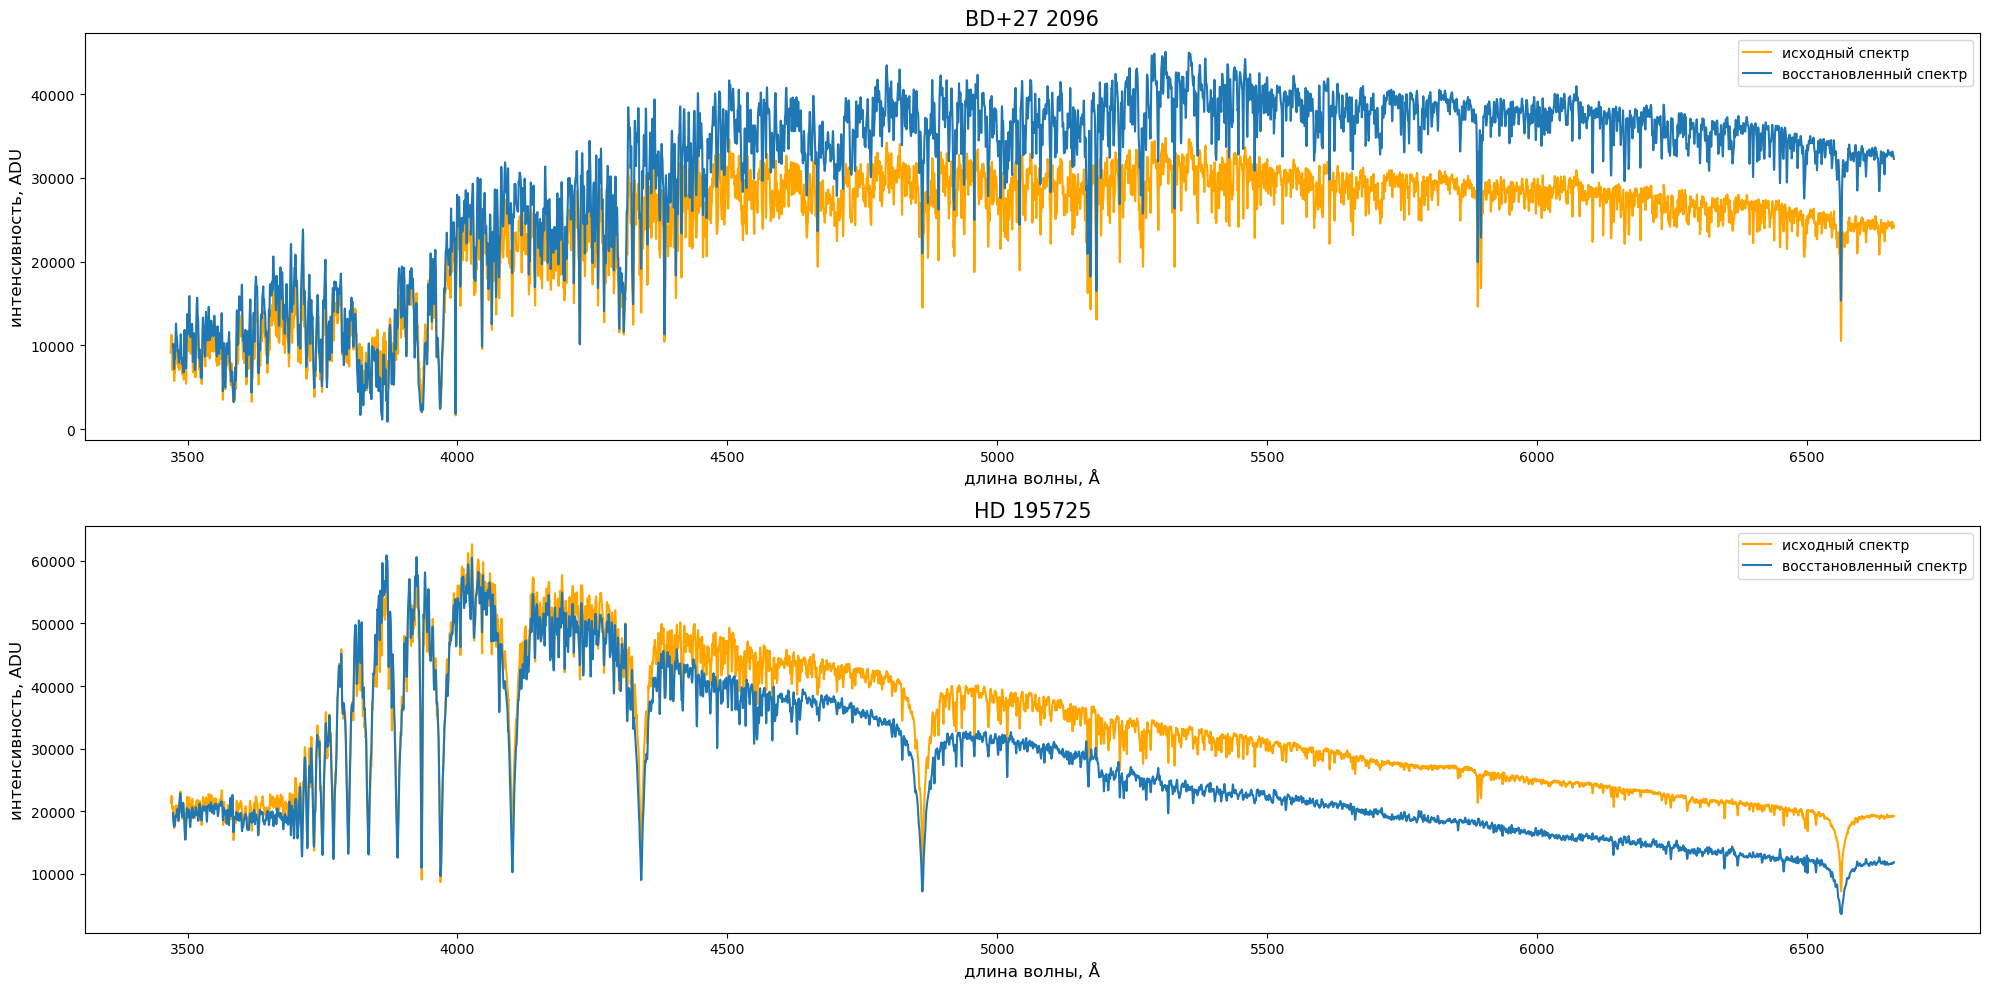

In [9]:
# Восстановление спектров

SPEC1 = np.zeros(end - start)
SPEC2 = np.zeros(end - start)

for i in range(end - start):
    SPEC1[i] = ((Cent1 - CENTER[i]) * pix_size / sep) * SPEC[i]
    SPEC2[i] = SPEC[i] - SPEC1[i]


fig2, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(Lambda[start:end], abs(Int1[start:end]), '-', ms=2, color='orange', label='исходный спектр')
axes[0].plot(LAMBDA[start:end], abs(SPEC2[start:end]), '-', ms=2, label='восстановленный спектр')
axes[0].set_xlabel("длина волны, Å", fontsize=12)
axes[0].set_ylabel("интенсивность, ADU", fontsize=12)
axes[0].set_title("BD+27 2096", fontsize=15)
axes[0].legend()

axes[1].plot(Lambda[start:end], abs(Int2[start:end]), '-', ms=2, color='orange', label='исходный спектр')
axes[1].plot(LAMBDA[start:end], abs(SPEC1[start:end]), '-', ms=2, label='восстановленный спектр')
axes[1].set_xlabel("длина волны, Å", fontsize=12)
axes[1].set_ylabel("интенсивность, ADU", fontsize=12)
axes[1].set_title("HD 195725", fontsize=15)
axes[1].legend()

plt.tight_layout()
plt.show()

Для звезд близких спектральных классов, в спектрах которых линии не смещены друг относительно друга вследствие эффекта Доплера, может оказаться невозможным применение предлагаемого здесь подхода из-за наложения линий. Боле того, даже в рассмотренном случае результат оказался несколько занижен (хоть и совпадает в пределах погрешности с истинным) из-за присутствия одних и тех же линий в спектрах обеих звезд.

Таким образом, системы с накладывающимися линиями находятся на пределе применимости метода. Для наиболее точного их анализа следует рассматривать максимально возможный диапазон длин волн и стараться анализировать линии во всех частях этого диапазона.